## Predictive Modelling Round 2.5

Based on the findings of the round 2, here're some findings:
* **Ensamble model** works the best. (Random forest tree classifier)
* Pipeline should be used also for data pre-processing due to the potential **data leakage** (interpolation, scaling etc.)
* forests are robust to the outliers, the scaling/clipping/PCA are not helpful

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline


## Import data

In [2]:
# import hpi data
hpi_path = 'C:/Users/ywa/Documents/Data/Predictive modelling/training_feature_hpi.xlsx'

# import moodle data
moodle_path = 'C:/Users/ywa/Documents/Data/Predictive modelling/training_feature_Moodle.xlsx'

df_hpi = pd.read_excel(hpi_path, sheet_name = 'Sheet1')
df_moodle = pd.read_excel(moodle_path, sheet_name = 'Sheet1')


In [3]:
# inspect two dataframes
df_hpi.head()
print(df_hpi.info())

df_moodle.head()
print(df_moodle.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   title                        74 non-null     object        
 1   language                     74 non-null     object        
 2   published_sections           74 non-null     int64         
 3   enrollments_total            74 non-null     int64         
 4   records_of_achievement       74 non-null     int64         
 5   category                     74 non-null     object        
 6   Date go-live                 74 non-null     datetime64[ns]
 7   Approx. date last enrolment  74 non-null     datetime64[ns]
 8   Mean_Q1                      68 non-null     float64       
 9   Mean_Q4                      68 non-null     float64       
 10  Sum_Q1                       70 non-null     float64       
 11  Sum_Q4                       70 non-null     fl

## Data Cleaning, Feature engineering

In [4]:
# timedelta for the duration of hpi data
df_hpi['duration'] = df_hpi['Approx. date last enrolment'] - df_hpi['Date go-live']

df_hpi['duration'] = df_hpi['duration'].astype('str')
df_hpi['duration'] = df_hpi['duration'].str.replace(' days', '')
df_hpi['duration'] = df_hpi['duration'].astype('int')

df_hpi.head()

,title,language,published_sections,enrollments_total,records_of_achievement,category,Date go-live,Approx. date last enrolment,Mean_Q1,Mean_Q4,Sum_Q1,Sum_Q4,label,duration
0,"""Learn2Trust - Vertrauen durch Verständnis von...",de,6,338,151,Med,2023-05-26,2024-12-03,3.083333,2.833333,37.0,34.0,Archived,557
1,"""Practising Artificial Intelligence""",en,7,294,20,Studieren,2023-09-01,2024-10-16,3.000000,3.000000,3.0,3.0,Archived,411
2,"""KI und Ethik""",de,44,131,0,Ethik,2020-06-26,2022-07-19,4.000000,4.000000,8.0,8.0,Archived,753
3,"""Learning Analytics für Lehrkräfte""",de,13,767,73,Schule,2023-09-12,2024-07-31,3.000000,2.480000,75.0,62.0,No update,323
4,"""Bildungsdatenkompetenz""",de,6,182,28,Schule,2023-09-01,2024-11-29,3.000000,2.571429,21.0,18.0,Archived,455


In [5]:
# concatenate two data sets (rename cols when necessary)

# check the col-names of two dataframes
print(df_hpi.columns)
print(df_moodle.columns)

# exclude columns from two dataframes
df_hpi = df_hpi.drop(['Approx. date last enrolment', 'Date go-live', 'Sum_Q1', 'Sum_Q4'], axis = 1)
df_moodle = df_moodle.drop(['courseID'], axis = 1)

print(df_hpi.shape)
print(df_moodle.shape)

# rename column
df_hpi = df_hpi.rename(columns = {'title' : 'courseName'})

print(df_hpi.info())
print(df_moodle.info())

df_data = pd.concat([df_hpi, df_moodle])

df_data.head()

Index(['title', 'language', 'published_sections', 'enrollments_total',
       'records_of_achievement', 'category', 'Date go-live',
       'Approx. date last enrolment', 'Mean_Q1', 'Mean_Q4', 'Sum_Q1', 'Sum_Q4',
       'label', 'duration'],
      dtype='object')
Index(['courseID', 'courseName', 'category', 'enrollments_total', 'language',
       'records_of_achievement', 'Mean_Q1', 'Mean_Q4', 'published_sections',
       'duration', 'label'],
      dtype='object')
(74, 10)
(41, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   courseName              74 non-null     object 
 1   language                74 non-null     object 
 2   published_sections      74 non-null     int64  
 3   enrollments_total       74 non-null     int64  
 4   records_of_achievement  74 non-null     int64  
 5   category                74 non-nul

,courseName,language,published_sections,enrollments_total,records_of_achievement,category,Mean_Q1,Mean_Q4,label,duration
0,"""Learn2Trust - Vertrauen durch Verständnis von...",de,6,338,151,Med,3.083333,2.833333,Archived,557
1,"""Practising Artificial Intelligence""",en,7,294,20,Studieren,3.000000,3.000000,Archived,411
2,"""KI und Ethik""",de,44,131,0,Ethik,4.000000,4.000000,Archived,753
3,"""Learning Analytics für Lehrkräfte""",de,13,767,73,Schule,3.000000,2.480000,No update,323
4,"""Bildungsdatenkompetenz""",de,6,182,28,Schule,3.000000,2.571429,Archived,455


In [39]:
# inspect missing values
print(df_data.shape)

df_data.isnull().sum()

na_mask = df_data[['Mean_Q1', 'Mean_Q4']].isnull()

df_missing = df_data[na_mask.any(axis = 1)]

df_missing

(115, 11)


,courseName,language,published_sections,enrollments_total,records_of_achievement,category,Mean_Q1,Mean_Q4,label,duration,learning_success
11,"""Künstliche Intelligenz in der Gesundheitsvers...",de,18,689,84,Med,NaN,NaN,no update,655,0.121916
13,"""Lernfabrik 4.0 - Steuerung , Monitoring und N...",de,9,88,0,Industry40,NaN,NaN,archived,294,0.000000
19,"""Dr. med. KI - Basler Modul""",de,9,234,206,Med,NaN,NaN,no update,647,0.880342
24,"""Deep Learning mit Tensorflow, Keras und Tenso...",de,12,766,85,ML,NaN,NaN,update,796,0.110966
27,"""Foundations of Artificial Intelligence VI""",en,7,205,19,Studieren,NaN,NaN,no update,872,0.092683
39,"""Applied Edge AI: Deep Learning Outside of the...",en,10,540,34,ML,NaN,NaN,archived,225,0.062963


In [40]:
# string cleaning - no space

df_data['language'] = df_data['language'].str.strip()
df_data['label'] = df_data['label'].str.strip()
df_data['label'] = df_data['label'].str.lower()

In [41]:
# DataFrame with NaN exclusion
df_data_clean = df_data.dropna()

df_data_clean.shape


(109, 11)

## Data inspection / EDA

In [42]:
# data type check
df_data.info()

print(df_data.label.unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 40
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   courseName              115 non-null    object 
 1   language                115 non-null    object 
 2   published_sections      115 non-null    int64  
 3   enrollments_total       115 non-null    int64  
 4   records_of_achievement  115 non-null    int64  
 5   category                115 non-null    object 
 6   Mean_Q1                 109 non-null    float64
 7   Mean_Q4                 109 non-null    float64
 8   label                   115 non-null    object 
 9   duration                115 non-null    int64  
 10  learning_success        115 non-null    float64
dtypes: float64(3), int64(4), object(4)
memory usage: 10.8+ KB
['archived' 'no update' 'update']


In [12]:
# numerical columns distribution check
df_data_num = df_data[['published_sections', 'enrollments_total', 'records_of_achievement', 'Mean_Q1', 'Mean_Q4', 'duration']]
df_data_num.head()
print(df_data_num.describe())


       published_sections  enrollments_total  records_of_achievement  \
count          115.000000         115.000000              115.000000   
mean             9.973913         955.347826               76.808696   
std              5.381027        1686.448058              121.918070   
min              4.000000          26.000000                0.000000   
25%              7.000000         222.500000                4.000000   
50%              8.000000         412.000000               26.000000   
75%             12.000000        1059.000000               85.500000   
max             44.000000       15470.000000              771.000000   

          Mean_Q1     Mean_Q4     duration  
count  109.000000  109.000000   115.000000  
mean     3.259646    2.925794   679.878261  
std      0.308075    0.323799   418.978418  
min      2.000000    2.000000    43.000000  
25%      3.086957    2.793103   293.500000  
50%      3.294118    2.939850   655.000000  
75%      3.469388    3.076923  1025.

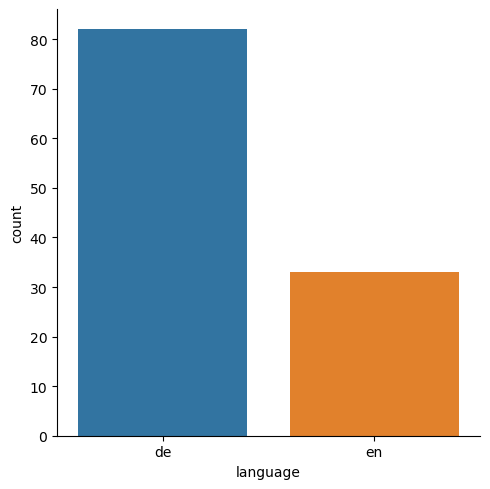

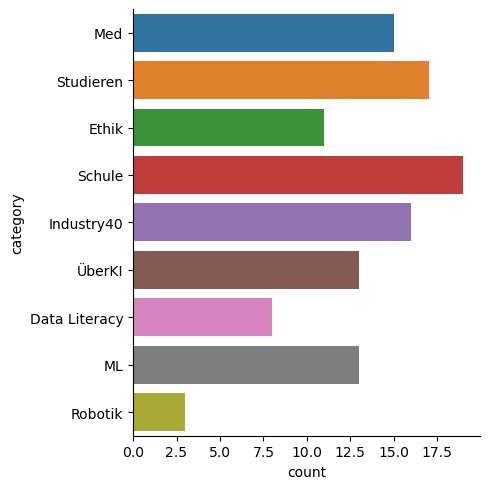

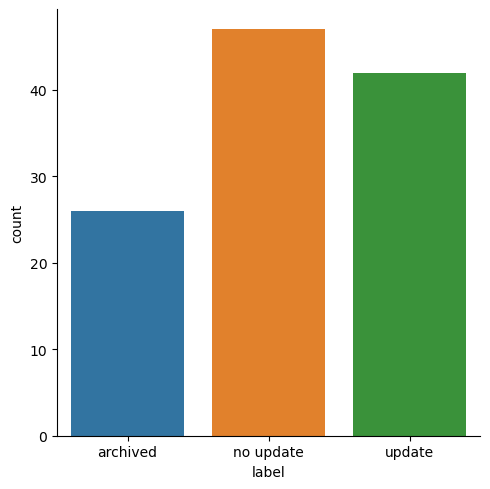

no update    47
update       42
archived     26
Name: label, dtype: int64

In [13]:
# visualisations

# for categorical features
# language
sns.catplot(data = df_data, x = 'language', kind = 'count')
plt.show()

# category
sns.catplot(data = df_data, y = 'category', kind = 'count')
plt.show()

# label
sns.catplot(data = df_data, x = 'label', kind = 'count')
plt.show()

df_data['label'].value_counts()


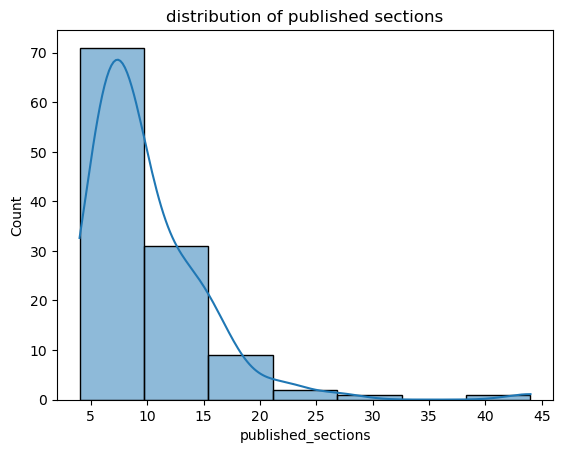

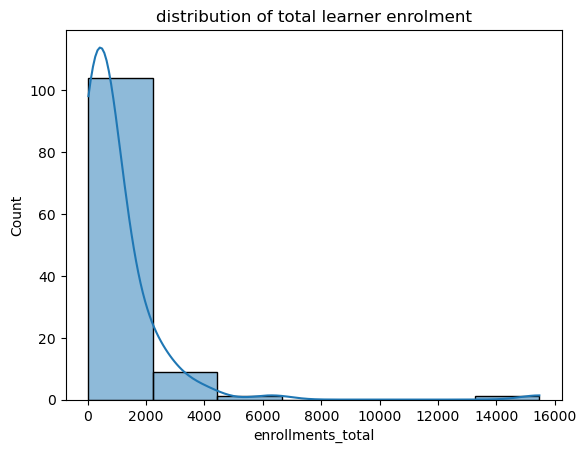

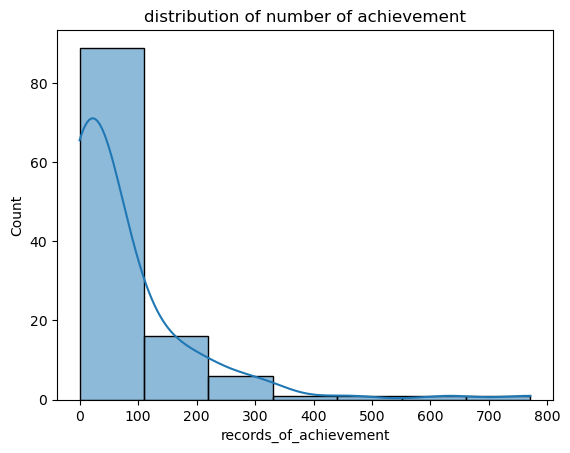

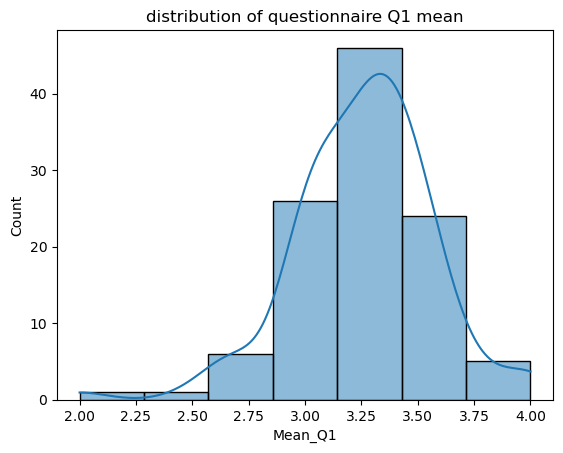

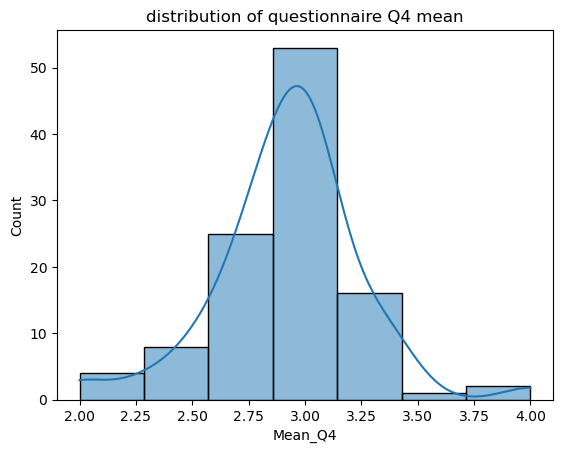

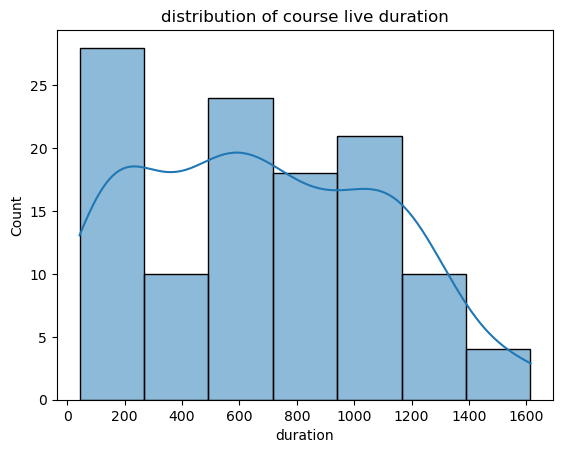

In [14]:
# for numerical data
# for numeric variables

# published_sections
sns.histplot(data = df_data, x = 'published_sections', bins = 7, kde = True)
plt.title('distribution of published sections')
plt.show()

# enrollments_total
sns.histplot(data = df_data, x = 'enrollments_total', bins = 7, kde = True)
plt.title('distribution of total learner enrolment')
plt.show()

# records_of_achievement
sns.histplot(data = df_data, x = 'records_of_achievement', bins = 7, kde = True)
plt.title('distribution of number of achievement')
plt.show()

# Mean_Q1 (exclude NAs) 
sns.histplot(data = df_data_clean, x = 'Mean_Q1', bins = 7, kde = True)
plt.title('distribution of questionnaire Q1 mean')
plt.show()

# Mean_Q4 (exclude NAs)
sns.histplot(data = df_data_clean, x = 'Mean_Q4', bins = 7, kde = True)
plt.title('distribution of questionnaire Q4 mean')
plt.show()

# duration
sns.histplot(data = df_data, x = 'duration', bins = 7, kde = True)
plt.title('distribution of course live duration')
plt.show()



C:\Users\ywa\AppData\Local\Temp\ipykernel_29952\4052880783.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  num_corr = df_data_clean.corr()


<Axes: >

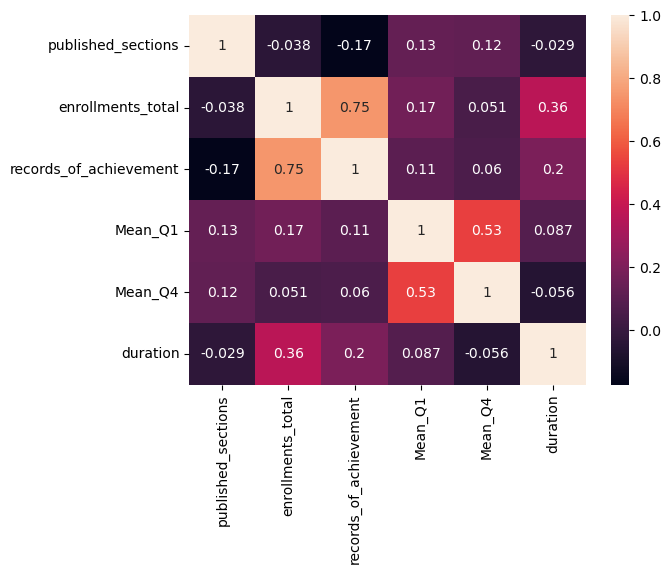

In [15]:
# correlation heatmap with clean DataFrame

num_corr = df_data_clean.corr()

sns.heatmap(num_corr, annot = True)

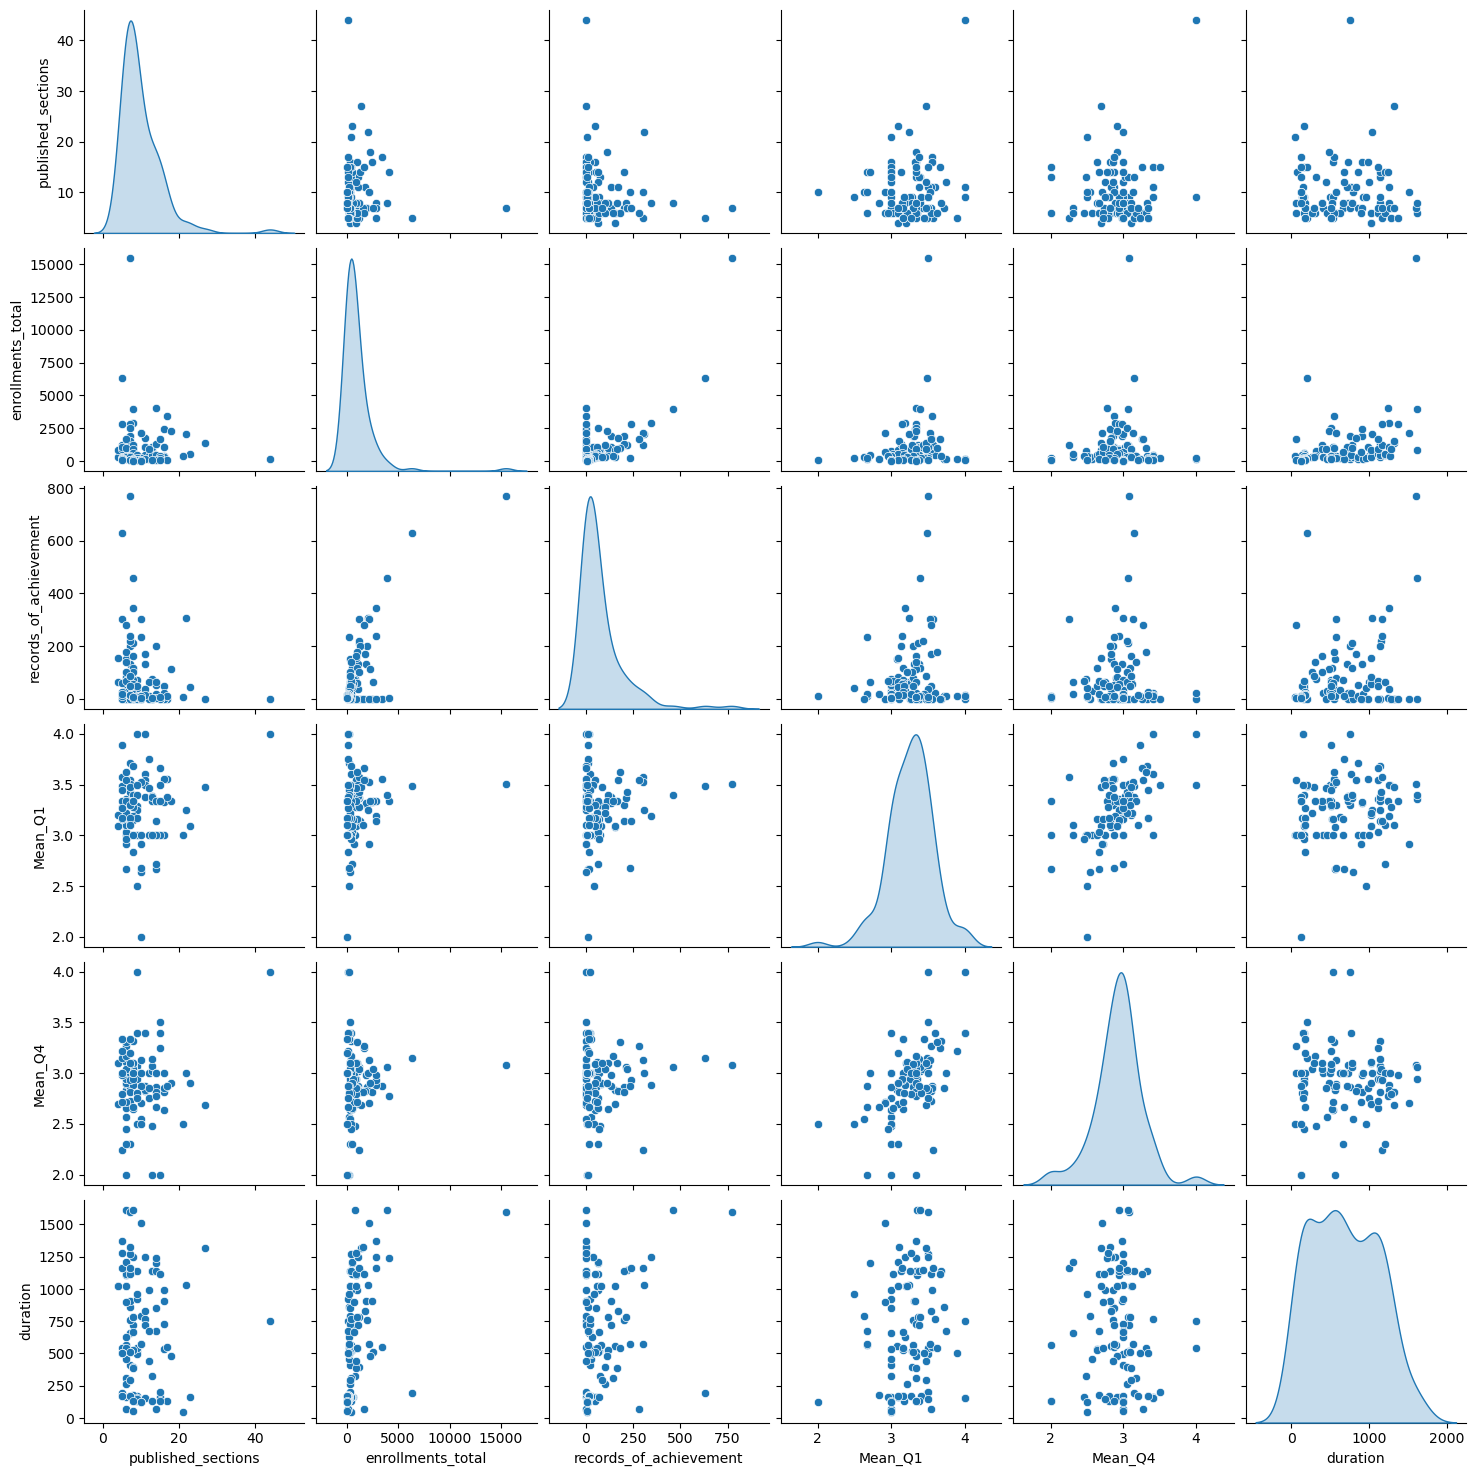

In [16]:
# pair plot for the numerical data
sns.pairplot(data = df_data_clean, kind = 'scatter', diag_kind = 'kde')
plt.show()

In [17]:
# use learning success instead of enrollments and record of achievement

df_data['learning_success'] = df_data['records_of_achievement'] / df_data['enrollments_total']

df_data_clean['learning_success'] = df_data_clean['records_of_achievement'] / df_data_clean['enrollments_total']


C:\Users\ywa\AppData\Local\Temp\ipykernel_29952\252337713.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_clean['learning_success'] = df_data_clean['records_of_achievement'] / df_data_clean['enrollments_total']


In [140]:
# drop columns and make visualisation again

#df_data = df_data.drop(['records_of_achievement', 'enrollments_total'], axis = 1)

#df_data_clean = df_data_clean.drop(['records_of_achievement', 'enrollments_total'], axis = 1)

### keep the two columns since the learning success <the ratio of RoA in enrollment> correlate negatively with the mean Q1 and mean Q4

C:\Users\ywa\AppData\Local\Temp\ipykernel_29952\1063051067.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  clean_corr = df_data_clean.corr()


<Axes: >

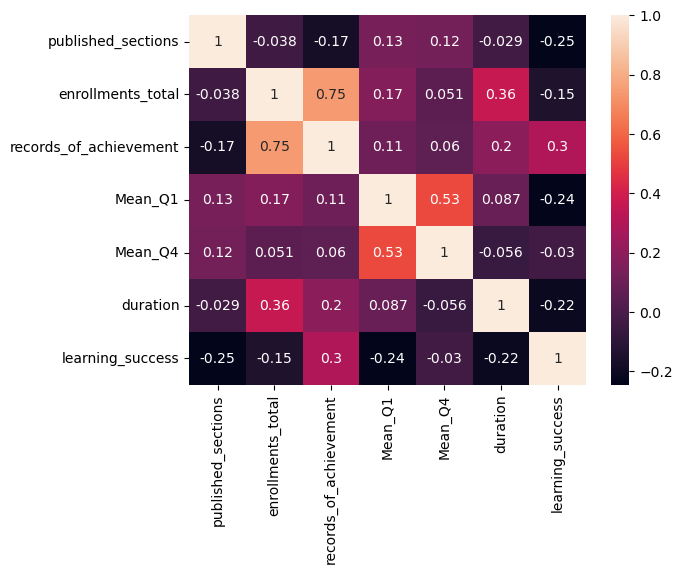

In [18]:
# heatmap
clean_corr = df_data_clean.corr()

sns.heatmap(clean_corr, annot = True)

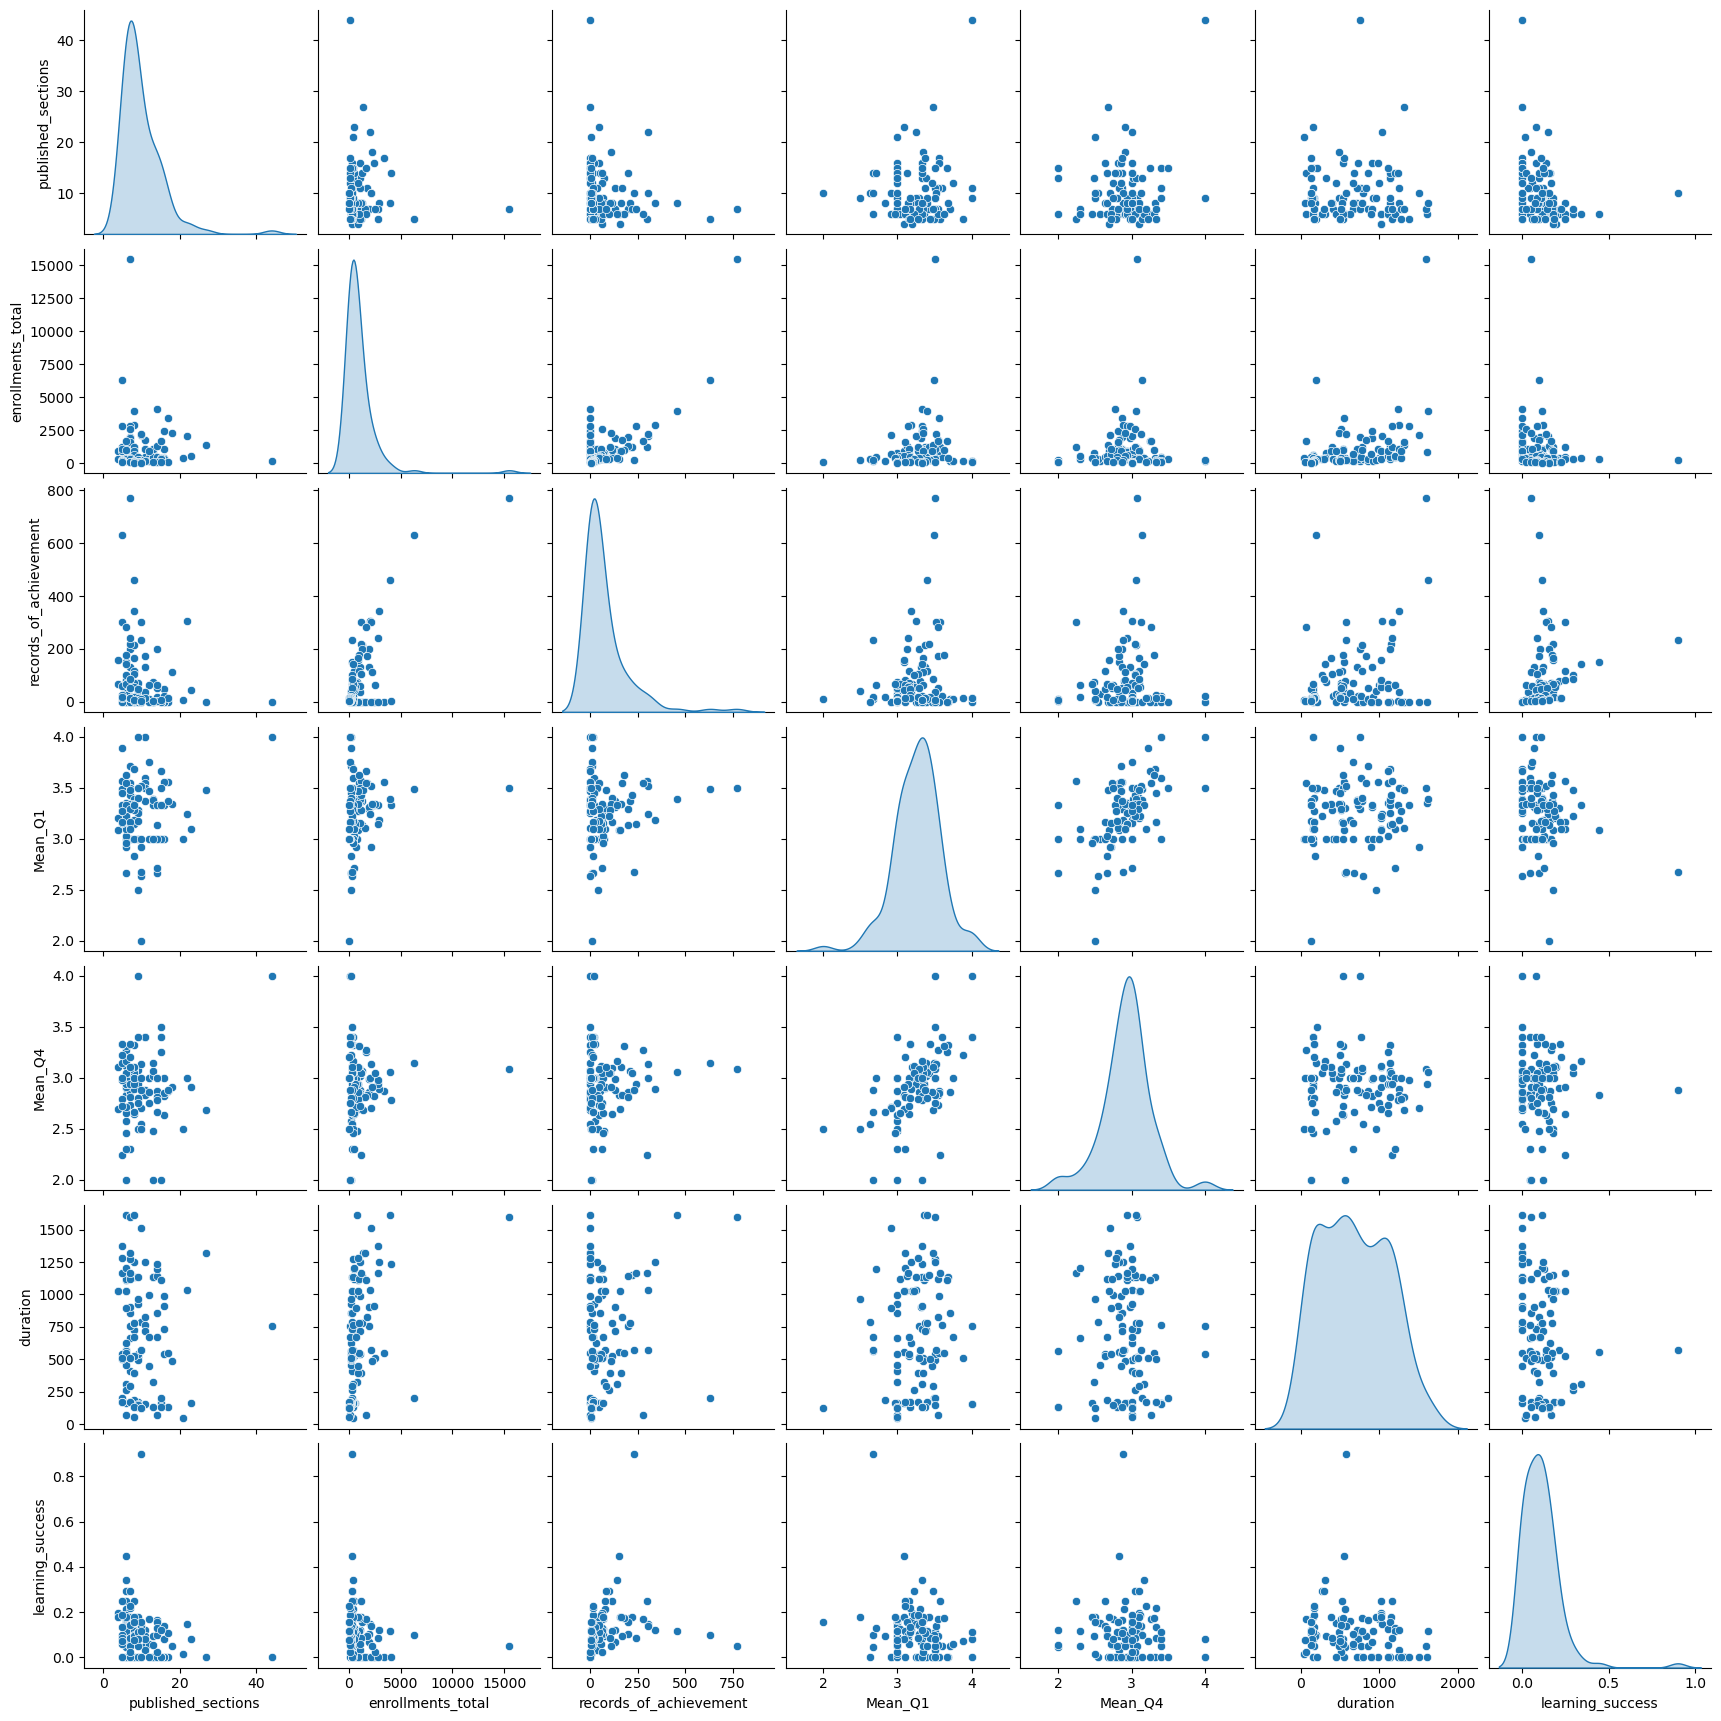

In [20]:
# pair plot
sns.pairplot(data = df_data_clean, kind = 'scatter', diag_kind = 'kde')
plt.show()


In [142]:
# export the dataset for binary labelling
#df_data_clean.to_excel('C:/Users/ywa/Documents/Data/Predictive modelling/clean_feature.xlsx')

## Create RFT pipeline

In [21]:
random_state = 40

In [22]:
# Split data

X = df_data.drop(['courseName', 'label'], axis = 1)

y = df_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 15, stratify = y, shuffle = True, random_state = random_state)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(100, 9)
(15, 9)
(100,)
(15,)


In [23]:
X_train.columns

Index(['language', 'published_sections', 'enrollments_total',
       'records_of_achievement', 'category', 'Mean_Q1', 'Mean_Q4', 'duration',
       'learning_success'],
      dtype='object')

In [48]:
# construct pipeline components

num_col = ['published_sections', 'enrollments_total','records_of_achievement', 'Mean_Q1', 'Mean_Q4', 'duration', 'learning_success']

cat_col = ['language', 'category']

imputer = SimpleImputer(strategy = 'median')

encoder = OneHotEncoder(drop = 'first', handle_unknown = 'ignore')

rfc = RandomForestClassifier(random_state = random_state)

preprocess = ColumnTransformer(transformers = [('imputer', imputer, num_col), ('encoder', encoder, cat_col)], remainder = 'drop')

pipe = Pipeline(steps = [('preprocess', preprocess), ('rfc', rfc)])



In [25]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10, random_state = random_state)

param_dict = {'rfc__n_estimators': np.arange(5, 100, 10),\
             'rfc__max_depth' : [None] + list(np.arange(3, 25, 1)),\
             'rfc__min_samples_split' : np.arange(2, 16, 1),\
             'rfc__min_samples_leaf' : np.arange(1, 10, 1), \
             'rfc__max_features' : ['sqrt', 'log2', None] + list(np.arange(0.2, 0.9, 0.2)), \
             'rfc__max_leaf_nodes' : [None] + list(np.arange(2, 10, 1)),\
             'rfc__bootstrap' : [True, False]}

random_search = RandomizedSearchCV(estimator = pipe, \
                                  param_distributions = param_dict, \
                                  n_iter = 150, \
                                  scoring = 'balanced_accuracy',\
                                  cv = cv, \
                                  n_jobs = -1, \
                                  verbose = 1, \
                                  random_state = random_state)

rfc_search = random_search.fit(X_train, y_train)

best_rfc = rfc_search.best_estimator_
y_pred = best_rfc.predict(X_test)

Fitting 50 folds for each of 150 candidates, totalling 7500 fits


In [26]:
y_pred.shape

(15,)

In [27]:
# evaluation starts here

# recall

recall = recall_score(y_test, y_pred, average = 'weighted')

# roc-auc

roc_auc = roc_auc_score(y_test, best_rfc.predict_proba(X_test), average = 'weighted', multi_class = 'ovo')


In [28]:
print(recall)

print(roc_auc)

0.6
0.8555555555555556


## Data recheck --> in case the features do not separate labels

In [34]:
# baseline model

# pipeline

scaler = StandardScaler()

logreg = LogisticRegression(max_iter = 3000, random_state = random_state)

num_transformer = Pipeline(steps = [('imputer', imputer), ('scaler', scaler)])

cat_transformer = Pipeline(steps = [('encoder', encoder)])

process_base = ColumnTransformer(transformers = [('num', num_transformer, num_col), ('cat', cat_transformer, cat_col)], remainder = 'drop')

pipe_base = Pipeline(steps = [('process_base', process_base), ('logreg', logreg)])


In [35]:
# random search cv

log_param = {'logreg__C' : np.logspace(-3, 2, 20), \
             'logreg__penalty' : ['l2'], \
             'logreg__solver': ['lbfgs'], \
             'logreg__multi_class': ['multinomial']}


baseline_search = RandomizedSearchCV(estimator = pipe_base, \
                                  param_distributions = log_param, \
                                  n_iter = 150, \
                                  scoring = 'balanced_accuracy',\
                                  cv = cv, \
                                  n_jobs = -1, \
                                  verbose = 1, \
                                  random_state = random_state)

log_search = baseline_search.fit(X_train, y_train)

best_log = log_search.best_estimator_
y_pred_base = best_log.predict(X_test)


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=150. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


In [36]:
# evaluation of the base line model

# recall
recall_base = recall_score(y_test, y_pred_base, average = 'weighted')

# roc-auc

roc_base = roc_auc_score(y_test, best_log.predict_proba(X_test), average = 'weighted', multi_class = 'ovo')


In [37]:
print(recall_base)

print(roc_base)

0.5333333333333333
0.7694444444444445


The baseline model underperforms the rfc, the next step is to check whether the result is due to the Model or due to the data.

## Learning curve

In [38]:
def learning_curve_estimate(model, X, y, train_sizes, test_size = 0.2, random_state = random_state):
    """
    model: estimator or pipeline (e.g., best_rfc or your pipeline)
    X, y: full dataset
    train_sizes: list of integers (number of samples for training)
    test_size: proportion for validation/test
    random_state: for reproducible splits
    """

    results = []

    for n in train_sizes:
        # 1. split full dataset once
        X_train_full, X_test, y_train_full, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state
        )

        # 2. sample only n examples from training set
        # stratified sampling:
        from sklearn.model_selection import StratifiedShuffleSplit
        sss = StratifiedShuffleSplit(n_splits=1, train_size=n, random_state=random_state)
        train_idx, _ = next(sss.split(X_train_full, y_train_full))

        X_train_n = X_train_full.iloc[train_idx]
        y_train_n = y_train_full.iloc[train_idx]

        # 3. fit the model on the reduced training set
        model.fit(X_train_n, y_train_n)

        # 4. evaluate on fixed test set
        y_pred = model.predict(X_test)
        bal_acc = balanced_accuracy_score(y_test, y_pred)

        results.append(bal_acc)
        print(f"Train size {n}: balanced accuracy = {bal_acc:.3f}")

    return results

C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train size 20: balanced accuracy = 0.433
Train size 40: balanced accuracy = 0.544
Train size 60: balanced accuracy = 0.628
Train size 80: balanced accuracy = 0.517
Train size 99: balanced accuracy = 0.433


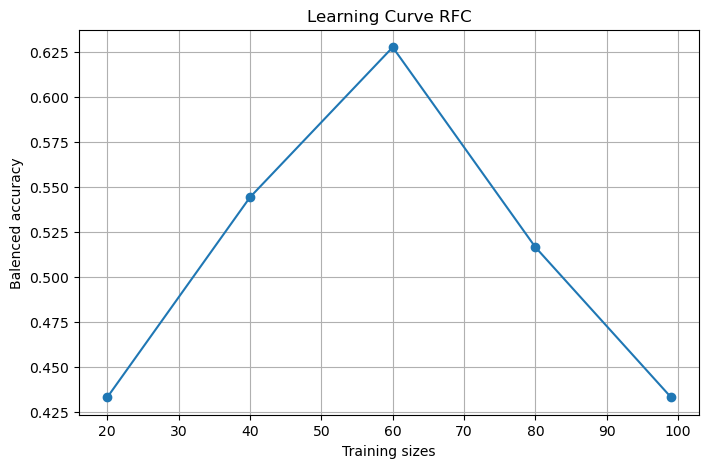

In [204]:
# run the function

#pipeline_curve = Pipeline(steps = [('preprocess', preprocess), ('rfc', best_rfc)])
# best_rfc already contains the preprocessing steps

train_sizes = [20, 40, 60, 80, 99]

results = learning_curve_estimate(model = best_rfc, X = X, y = y, train_sizes = train_sizes, test_size = 0.1, random_state = random_state)

# plot the learning rate

plt.figure(figsize=(8,5))
plt.plot(train_sizes, results, marker = 'o')
plt.title('Learning Curve RFC')
plt.xlabel('Training sizes')
plt.ylabel('Balenced accuracy')
plt.grid(True)
plt.show()

## Clustering the data without labels --> checking patterns

In [49]:
# import dependencies

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [51]:
# build pipe line --> using the same preprocess in the previous cell

#num_col = ['published_sections', 'enrollments_total','records_of_achievement', 'Mean_Q1', 'Mean_Q4', 'duration', 'learning_success']

#cat_col = ['language', 'category']

#imputer = SimpleImputer(strategy = 'median')

#encoder = OneHotEncoder(drop = 'first', handle_unknown = 'ignore')

#preprocess = ColumnTransformer(transformers = [('imputer', imputer, num_col), ('encoder', encoder, cat_col)], remainder = 'drop')

pca = PCA(n_components = 0.9, random_state = random_state)

scores = []

k = range(2, 9)

for n in k:
    kmean = KMeans(n_clusters = n, random_state = random_state, n_init = 10)
    X_embedded = Pipeline(steps = [('preprocess', preprocess), ('pca', pca)]).fit_transform(X)
    cluster_labels = kmean.fit_predict(X_embedded)
    scores.append(silhouette_score(X_embedded, cluster_labels))
    
print(list(zip(k, scores)))

C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

[(2, 0.9239703501338798), (3, 0.7292538694108094), (4, 0.6741670537326588), (5, 0.6564323612441306), (6, 0.6572301087094176), (7, 0.6608395070508237), (8, 0.5495209385540673)]


The clustering shows:
* 2 clusters exhibit the highest silhouette score --> the dataset is separated in two groups in nature
* labelling 2 clusters with 3 lables explained the issues in the performance of the ensemble
* checking cluster vs. lable alginment

## Inspecting cluster vs. dataset

In [52]:
# get the k = 2 cluster labels

kmean_opt = KMeans(n_clusters = 2, random_state = random_state, n_init = 10)

X_embedded = Pipeline(steps = [('preprocess', preprocess), ('pca', pca)]).fit_transform(X)

cluster_labels = kmean_opt.fit_predict(X_embedded)


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


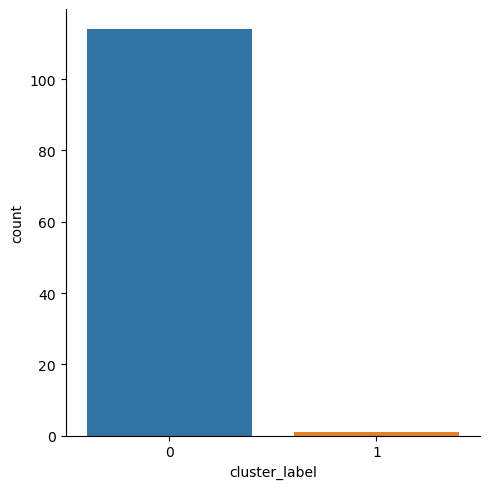

In [58]:
# add cluster labels to the original dataframe 

df_data['cluster_label'] = cluster_labels

sns.catplot(data = df_data, x = 'cluster_label', kind = 'count')
plt.show()

In [60]:
df_data['cluster_label'].value_counts()

0    114
1      1
Name: cluster_label, dtype: int64

## Conclusion
Unsupervised analysis (KMeans in PCA-embedded feature space) did not reveal meaningful cluster structure. The algorithm consistently produced one dominant cluster and isolated outliers, indicating the absence of natural groupings. This aligns with supervised results, where multiple classifiers plateaued at moderate performance and learning curves exhibited high variance. Together, these findings suggest that the current feature set does not support well-separated class structure, and model performance is limited primarily by data characteristics rather than model choice.

## Ranking approach

In [71]:
# diagnostic

# check classes
print(best_rfc.classes_)

y_score = best_rfc.predict_proba(X)[:, 2]

['archived' 'no update' 'update']


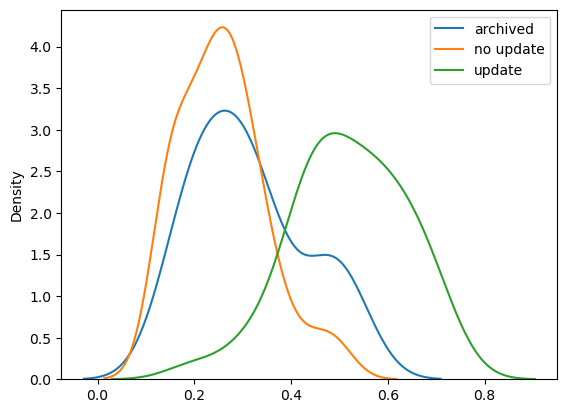

In [73]:
sns.kdeplot(y_score[y == 'archived'], label = 'archived')
sns.kdeplot(y_score[y == 'no update'], label = 'no update')
sns.kdeplot(y_score[y == 'update'], label = 'update')

plt.legend()